## AutoGluon

This notebook contains:
- Code for training AutoGluon models to classify texts as being either LLM-generated or human-written.
- Code for calculating and visualizing SHAP values (feature importance) of the best performing model

In [2]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import shap
from scipy.sparse import load_npz
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
import pickle



In [2]:
train_data_x_sparse = load_npz('../data/train_data_x_sparse.npz')
train_data_x_dense = pd.read_csv('../data/train_data_x_dense.csv')
validation_data_x_sparse = load_npz('../data/valid_data_x_sparse.npz')
validation_data_x_dense = pd.read_csv('../data/valid_data_x_dense.csv')
pretest_data_x_sparse = load_npz('../data/pretest_data_x_sparse.npz')
pretest_data_x_dense = pd.read_csv('../data/pretest_data_x_dense.csv')
test_data_x_sparse = load_npz('../data/test_data_x_sparse.npz')
test_data_x_dense = pd.read_csv('../data/test_data_x_dense.csv')

train_data_x = pd.DataFrame(hstack([train_data_x_sparse, csr_matrix(train_data_x_dense.values)]).toarray())
validation_data_x = pd.DataFrame(hstack([validation_data_x_sparse, csr_matrix(validation_data_x_dense.values)]).toarray())
pretest_data_x = pd.DataFrame(hstack([pretest_data_x_sparse, csr_matrix(pretest_data_x_dense.values)]).toarray())
test_data_x = pd.DataFrame(hstack([test_data_x_sparse, csr_matrix(test_data_x_dense.values)]).toarray())
train_data_y = pd.read_csv('../data/train_data_y.csv')
validation_data_y = pd.read_csv('../data/valid_data_y.csv')
pretest_data_y = np.ravel(pd.read_csv('../data/pretest_data_y.csv'))
test_data_y = np.ravel(pd.read_csv('../data/test_data_y.csv'))

train_data = pd.concat([train_data_x, pd.DataFrame(train_data_y)], axis=1)
validation_data = pd.concat([validation_data_x, pd.DataFrame(validation_data_y)], axis=1)

with open('../data/sparse_matrices_feature_names.pkl', 'rb') as f:
    sparse_matrices_feature_names = pickle.load(f)

all_feature_names = list(sparse_matrices_feature_names) + list(train_data_x_dense.columns)
dense_feature_indices = [all_feature_names.index(feature) for feature in train_data_x_dense.columns]
dense_feature_names = list(train_data_x_dense.columns) # Engineered features
sparse_feature_indices = [all_feature_names.index(feature) for feature in sparse_matrices_feature_names]
sparse_feature_names = list(sparse_matrices_feature_names) # TF-IDF features


In [3]:
autoglon_classifier = TabularPredictor(label='generated', problem_type="binary", eval_metric="f1")

autoglon_classifier.fit(train_data=train_data, tuning_data=validation_data)


No path specified. Models will be saved in: "AutogluonModels/ag-20240420_100942"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240420_100942"
=================== System

In [3]:
# Loading the best performing AutoGluon model from file, based on result of fitting

best_classifier = TabularPredictor.load("AutogluonModels/ag-20240420_100942")

In [8]:
print(best_classifier.model_names()) # The model names of the ensemble

['RandomForestGini', 'RandomForestEntr', 'ExtraTreesGini', 'ExtraTreesEntr', 'WeightedEnsemble_L2']


In [14]:
train_data_f1_score = f1_score(train_data_y, best_classifier.predict(train_data_x))
pretest_data_f1_score = f1_score(pretest_data_y, best_classifier.predict(pretest_data_x))
test_data_f1_score = f1_score(test_data_y, best_classifier.predict(test_data_x))

print(f"{'':<20s}{'|':<8s}{'Best AutoGluon model':<27s}{'|'}")
print(f"{'-' * 20}{'|'}{'-' * 17}{'+'}{'-' * 16}{'|'}")
print(f"{'F1 score train':<20s}{'|':<15s}{train_data_f1_score:<20.4f}{'|'}")
print(f"{'F1 score pretest':<20s}{'|':<15s}{pretest_data_f1_score:<20.4f}{'|'}")
print(f"{'F1 score test':<20s}{'|':<15s}{test_data_f1_score:<20.4f}{'|'}")

                    |       Best AutoGluon model       |
--------------------|-----------------+----------------|
F1 score train      |              1.0000              |
F1 score pretest    |              0.9112              |
F1 score test       |              0.9538              |


In [4]:
# Samples used for calculating SHAP values

shap_samples = shap.sample(test_data_x, 50, random_state=42)
dense_shap_samples = shap_samples.iloc[:, dense_feature_indices]
sparse_shap_samples = shap_samples.iloc[:, sparse_feature_indices]

In [5]:
# Use Shap to explain the model

samples_columns = shap_samples.columns

# Custom function to enable shap value calculations
# Inspiration found here: https://github.com/shap/shap/issues/1436
def best_classifier_predict(X):
    df = pd.DataFrame(X, columns=samples_columns)
    return best_classifier.predict(df)

train_data_x_for_explainer = np.array(shap_samples.values.tolist())

explainer = shap.KernelExplainer(best_classifier_predict, train_data_x_for_explainer)

shap_values = explainer.shap_values(shap_samples, num_workers=8)
dense_shap_values = shap_values[:, dense_feature_indices]
sparse_shap_values = shap_values[:, sparse_feature_indices]

  0%|          | 0/50 [00:00<?, ?it/s]

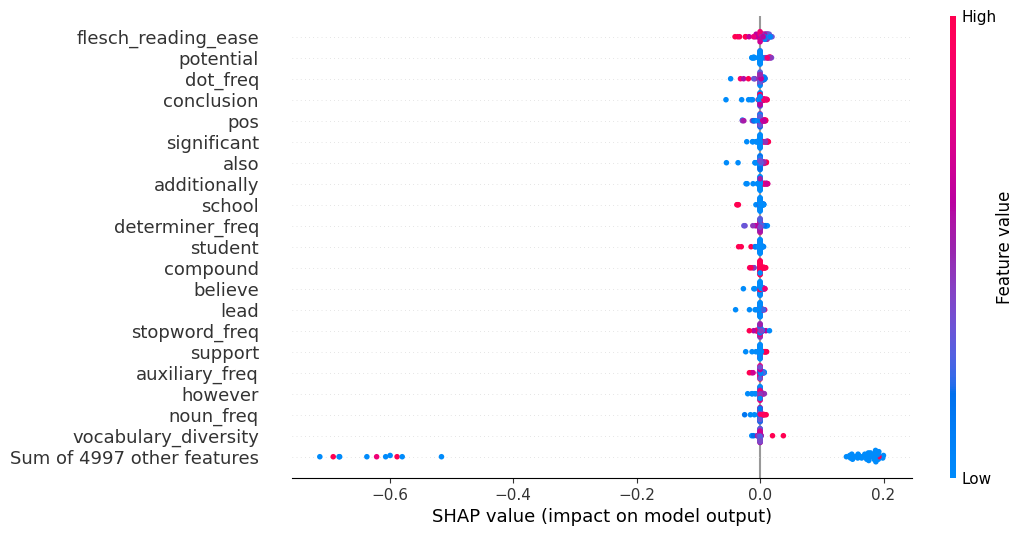

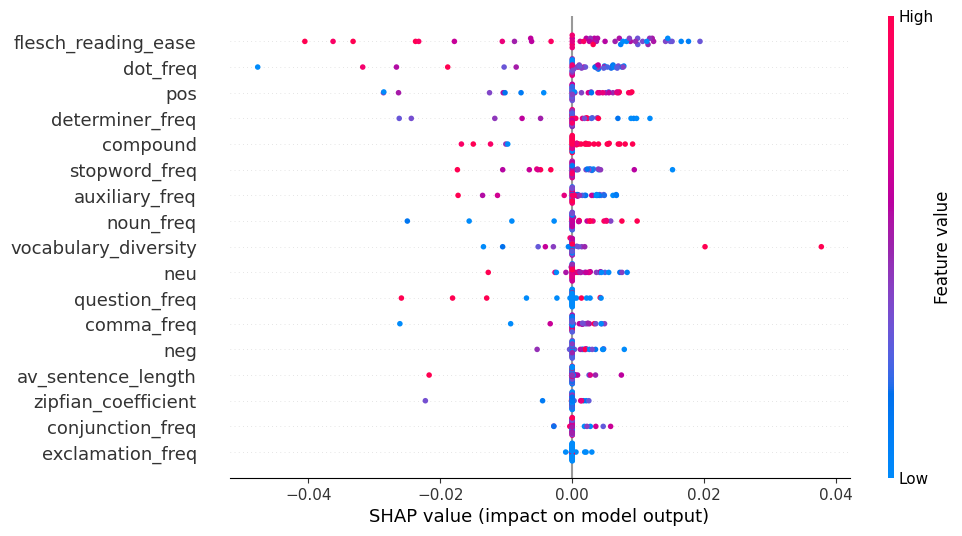

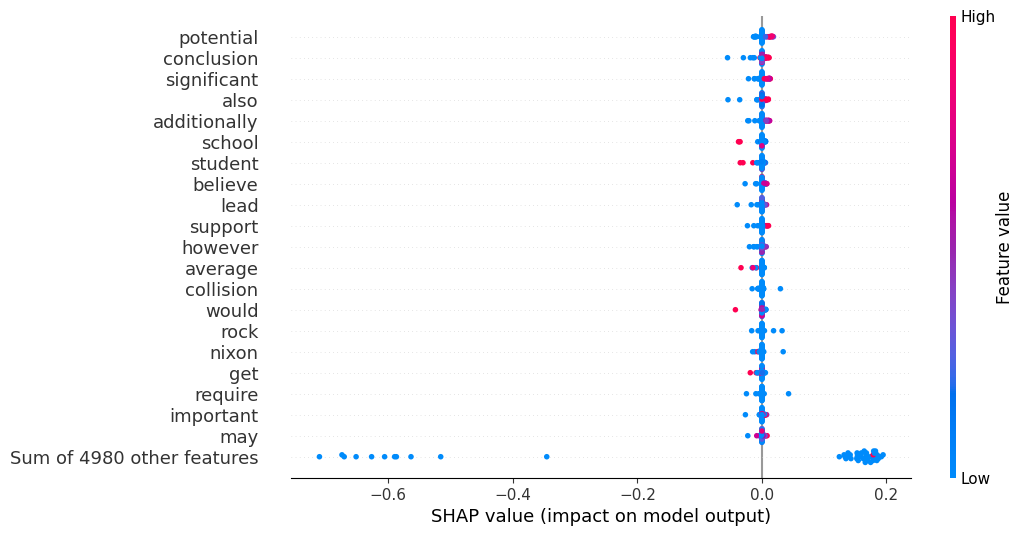

In [12]:
# Visualizing feature importance through beeswarm plots

shap.plots.beeswarm(
    shap.Explanation(values=shap_values, data=shap_samples, feature_names=all_feature_names),
    max_display=21,
    plot_size=(10, 6),
)

shap.plots.beeswarm(
    shap.Explanation(values=dense_shap_values, data=dense_shap_samples, feature_names=dense_feature_names),
    max_display=21,
    plot_size=(10, 6)
)

shap.plots.beeswarm(
    shap.Explanation(values=sparse_shap_values, data=sparse_shap_samples, feature_names=sparse_feature_names),
    max_display=21,
    plot_size=(10, 6)
)